**数据集：**

采用前13天（13days/30s）没有空缺数据的数据集进行训练和检验

**预测目标：**

超短期预测（4h/15min）的风功率

**可调的参数：**
- 使用前多久的数据进行预测:400
- 数据集的特征: speed power
- 使用多少天的数据进行训练: 6 days
- LSTM units 数目: 100
- batch size: 72
- epoch: 100

In [2]:
n = 1
# 使用前400个点的 speed & power 预测接下来 4h(4h/15min) 的power
n_back = 400
n_out = 16
n_pre = n_out*15*2
n_feature = 2
# 使用前6天的数据进行训练
train_len = 8
# 神经网络参数
units = 50
rounds = 100
size = 72

# Preperation

In [3]:
from math import sqrt
import numpy as np
import pandas as pd

from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU

2023-01-09 20:26:18.483993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 20:26:18.933690: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-09 20:26:18.933730: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-09 20:26:20.761824: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
dataset = pd.read_csv('../wind_preprocessed.csv', header=0, index_col=0).query('day<14')

In [5]:
data = dataset[['speed_moveavg', 'power_moveavg']].rename(columns={'power_moveavg':'power', 'speed_moveavg':'speed'})
print(data.head())

                       speed    power
date                                 
2015-10-01 00:00:00  0.39627  0.38065
2015-10-01 00:00:30  0.39592  0.36943
2015-10-01 00:01:00  0.39538  0.38529
2015-10-01 00:01:30  0.39579  0.38892
2015-10-01 00:02:00  0.39627  0.41220


In [6]:
values = data.values
values = values.astype('float32')

def series_to_supervised(data, n_in, n_out, colname, dropnan=True):
    n_vars = colname
    # n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in n_vars]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out, 15*2):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in n_vars]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in n_vars]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 构建成监督学习问题
reframed = series_to_supervised(values, n_back, n_pre, ['speed', 'power'])
# 丢弃我们不想预测的列
for i in range(0, n_pre, 15*2):
    if i == 0:
        colname = 'speed(t)'
    else:
        colname = f'speed(t+{i})'
    reframed.drop(colname, axis=1, inplace=True)
# print(reframed.head(5))

In [7]:
# 分割为训练集和测试集
values = reframed.values
n_train_hours = train_len*24*60*2
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# 分为输入输出
n_obs = n_back * n_feature
train_X, train_y = train[:, :n_obs], train[:, -n_out:]
test_X, test_y = test[:, :n_obs], test[:, -n_out:]
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)
# 重塑成3D格式 [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_back, n_feature))
test_X = test_X.reshape((test_X.shape[0], n_back, n_feature))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(23040, 800) (23040, 16)
(13550, 800) (13550, 16)
(23040, 400, 2) (23040, 16) (13550, 400, 2) (13550, 16)


In [22]:
model = Sequential()
model.add(GRU(units, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_out))

model.load_weights('gru_1.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 50)                8100      
                                                                 
 dense_1 (Dense)             (None, 16)                816       
                                                                 
Total params: 8,916
Trainable params: 8,916
Non-trainable params: 0
_________________________________________________________________


# Testing

In [9]:
# 预测test_X中前100个sample
from tqdm import trange
sigmas = []
rmses = []
for i in trange(100):
    yhat = model.predict(test_X[i][:][:].reshape(1, n_back, 2), verbose=0)[0]
    yreal = test_y.reshape((len(test_y), n_out))[i]
    rmse = sqrt(mean_squared_error(yreal, yhat))
    sigma = np.mean((yhat - yreal) / yreal * 100)
    rmses.append(rmse)
    sigmas.append(sigma)

100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


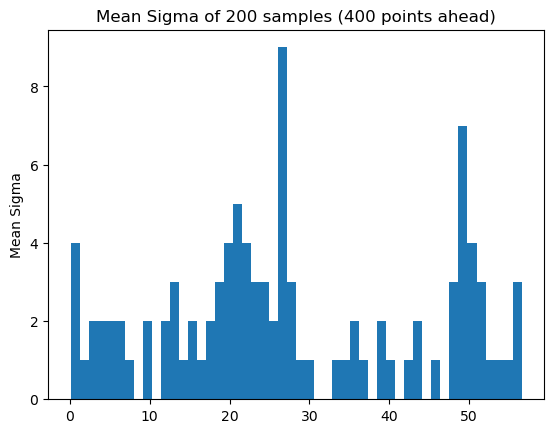

In [10]:
plt.hist(sigmas, bins=50)
plt.ylabel('Mean Sigma')
plt.title('Mean Sigma of 200 samples (400 points ahead)')
# plt.xlim(0, 100)
plt.show()

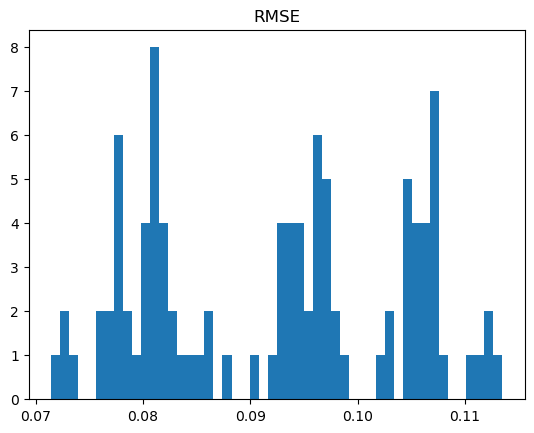

In [11]:
plt.hist(rmses, bins=50)
plt.title('RMSE')
plt.show()

## Test Prediction

In [12]:
# 随机指定test_X中的一个sample看预测效果
i = 1

In [13]:
# 做出预测
yhat = model.predict(test_X[i][:][:].reshape(1, n_back, 2))[0]
yreal = test_y.reshape((len(test_y), n_out))[i]

1/1 [==============================] - 0s 91ms/step


In [14]:
# 计算RMSE
rmse = sqrt(mean_squared_error(yreal, yhat))
# 计算平均相对误差
sigma = np.mean((yhat - yreal) / yreal * 100)

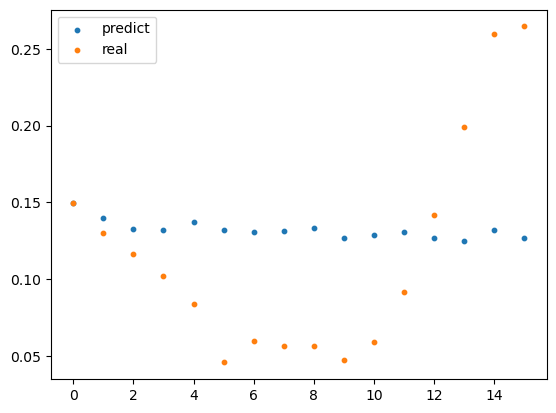

In [15]:
t = np.arange(0, len(yhat), 1)
plt.scatter(t, yhat, label='predict', s=10)
plt.scatter(t, yreal, label='real', s=10)
plt.legend()

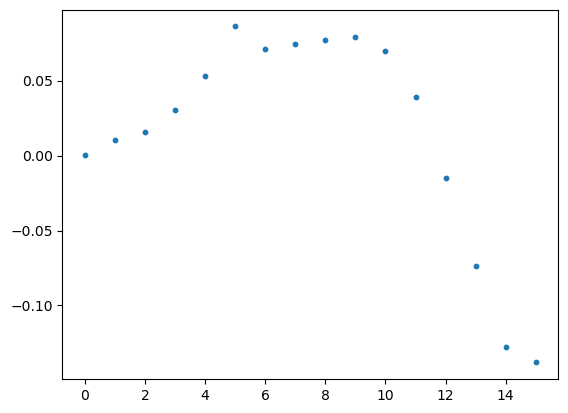

In [16]:
t = np.arange(0, len(yhat), 1)
plt.scatter(t, yhat-yreal, s=10)

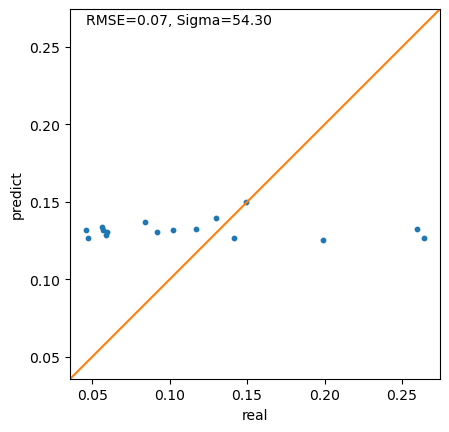

In [17]:
x = np.arange(0, 1, 0.1)
plt.plot(x, x, color='C1')
plt.scatter(yreal, yhat, s=10)
# plt.plot(yreal, yreal, color='C1')
plt.xlabel('real')
plt.ylabel('predict')
plt.gca().set_aspect(1)
plt.xlim(min(min(yreal), min(yhat))-0.01, max(max(yreal), max(yhat))+0.01)
plt.ylim(min(min(yreal), min(yhat))-0.01, max(max(yreal), max(yhat))+0.01)
plt.text(min(min(yreal), min(yhat)), max(max(yreal), max(yhat)), 'RMSE={:.2f}, Sigma={:.2f}'.format(rmse, sigma))
plt.show()

## Train Prediction

In [18]:
# 随机指定train_X中的一个sample看预测效果
i = 1000
# 做出预测
yhat = model.predict(train_X[i][:][:].reshape(1, n_back, 2))[0]
yreal = train_y.reshape((len(train_y), n_out))[i]

1/1 [==============================] - 0s 165ms/step


In [19]:
# 计算RMSE
rmse = sqrt(mean_squared_error(yreal, yhat))
print('Test RMSE: %.3f' % rmse)
# 计算平均相对误差
sigma = np.mean((yhat - yreal) / yreal * 100)
print(sigma)

Test RMSE: 0.043
117.437546


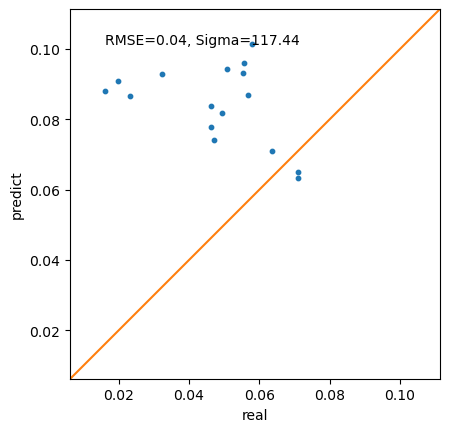

In [20]:
x = np.arange(0, 1, 0.1)
plt.plot(x, x, color='C1')
plt.scatter(yreal, yhat, s=10)
# plt.plot(yreal, yreal, color='C1')
plt.xlabel('real')
plt.ylabel('predict')
plt.gca().set_aspect(1)
plt.xlim(min(min(yreal), min(yhat))-0.01, max(max(yreal), max(yhat))+0.01)
plt.ylim(min(min(yreal), min(yhat))-0.01, max(max(yreal), max(yhat))+0.01)
plt.text(min(min(yreal), min(yhat)), max(max(yreal), max(yhat)), 'RMSE={:.2f}, Sigma={:.2f}'.format(rmse, sigma))
plt.show()

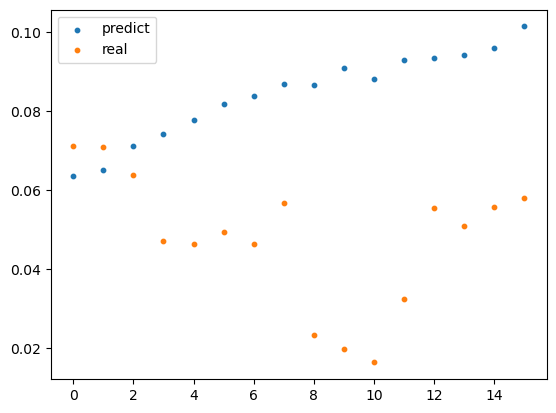

In [21]:
t = np.arange(0, len(yhat), 1)
plt.scatter(t, yhat, label='predict', s=10)
plt.scatter(t, yreal, label='real', s=10)
plt.legend()